*Created by Petteri Nevavuori (<petteri.nevavuori@jamk.fi>)*

---
# Appendix A. Re-training the Model

In this notebook we will train our model once more with the hyperparamers found during the optimization process. We will also visualize how our trained model's output matches to the real target values.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-Initializations" data-toc-modified-id="Imports-and-Initializations-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and Initializations</a></span></li><li><span><a href="#Retraining-with-Found-Hyperparameters" data-toc-modified-id="Retraining-with-Found-Hyperparameters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Retraining with Found Hyperparameters</a></span></li><li><span><a href="#Assessing-Model-Performance" data-toc-modified-id="Assessing-Model-Performance-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Assessing Model Performance</a></span></li></ul></div>

## Imports and Initializations

Thus we initialize the later RGB dataset with largest image size and the model with eight CNN layers, Adadelta as the optimization algorithm, learning rate at 0.1, L2-regularization coefficient at 1.0 and the rho-parameter at 0.3.

In [2]:
from torch import optim
from field_analysis.model.nets.cnn import DroneYieldMeanCNN
from field_analysis.model.dataset.dataperiod import DroneRGBLater
DB_128 = 'field_analysis_40m_128px.db'

dataset = DroneRGBLater(db_name=DB_128)
cnn = DroneYieldMeanCNN(
    source_bands=3,
    source_dim=128,
    cnn_layers=8,
    optimizer=optim.Adadelta,
    optimizer_parameters={'weight_decay': 1.0,
                          'lr': 0.1,
                          'rho': 0.3})

## Retraining with Found Hyperparameters

We will perform Early Stopping training here too.

Starting the training with GPU:
[  13/ 250] (8m 54s) 	Mean Loss:	Train=529.52 +-504.53	Test=807.62 +-646.81
[  26/ 250] (17m 43s) 	Mean Loss:	Train=423.30 +-310.37	Test=646.25 +-522.98
[  39/ 250] (26m 31s) 	Mean Loss:	Train=344.67 +-249.72	Test=470.26 +-362.88
[  52/ 250] (35m 20s) 	Mean Loss:	Train=264.72 +-200.99	Test=369.81 +-327.89
[  65/ 250] (44m  9s) 	Mean Loss:	Train=252.63 +-180.89	Test=555.63 +-524.45
[  78/ 250] (52m 57s) 	Mean Loss:	Train=233.40 +-172.25	Test=340.89 +-292.10
[  91/ 250] (61m 46s) 	Mean Loss:	Train=207.54 +-150.43	Test=447.27 +-373.27
[ 104/ 250] (70m 35s) 	Mean Loss:	Train=193.65 +-141.99	Test=421.77 +-396.64
[ 117/ 250] (79m 23s) 	Mean Loss:	Train=195.00 +-148.54	Test=523.73 +-505.78
[ 130/ 250] (88m 12s) 	Mean Loss:	Train=174.52 +-125.34	Test=444.91 +-372.84
[ 138/ 250] (93m 37s) 	Mean Loss:	Train=164.66 +-123.31	Test=477.87 +-429.26
Early stopping criterion met, terminating training.
Saving the model to /home/nevape/projektit/crop-yield-cnn/models/cnn_3

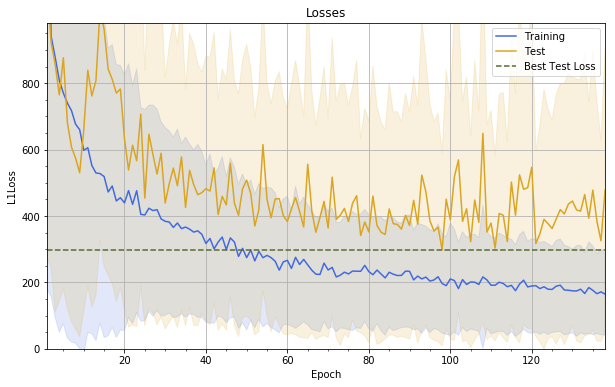

Starting the training with GPU:
[  13/ 250] (8m 48s) 	Mean Loss:	Train=175.64 +-125.89	Test=310.61 +-295.31
[  26/ 250] (17m 36s) 	Mean Loss:	Train=175.69 +-131.49	Test=349.59 +-313.20
[  39/ 250] (26m 25s) 	Mean Loss:	Train=158.14 +-117.66	Test=375.50 +-351.97
[  52/ 250] (35m 13s) 	Mean Loss:	Train=151.85 +-107.65	Test=371.46 +-357.05
[  65/ 250] (44m  2s) 	Mean Loss:	Train=138.24 +-106.52	Test=366.50 +-364.39
[  78/ 250] (52m 50s) 	Mean Loss:	Train=144.30 +-105.29	Test=293.57 +-286.69
[  91/ 250] (61m 38s) 	Mean Loss:	Train=136.45 +-96.55	Test=311.98 +-315.45
[ 104/ 250] (70m 27s) 	Mean Loss:	Train=146.34 +-109.66	Test=284.06 +-268.43
[ 117/ 250] (79m 15s) 	Mean Loss:	Train=128.68 +-95.40	Test=332.61 +-329.27
[ 130/ 250] (88m  3s) 	Mean Loss:	Train=132.90 +-99.04	Test=307.16 +-335.44
[ 143/ 250] (96m 52s) 	Mean Loss:	Train=139.41 +-99.28	Test=293.39 +-317.35
[ 156/ 250] (105m 41s) 	Mean Loss:	Train=128.61 +-97.11	Test=287.19 +-317.35
[ 169/ 250] (114m 30s) 	Mean Loss:	Train=131.01 +

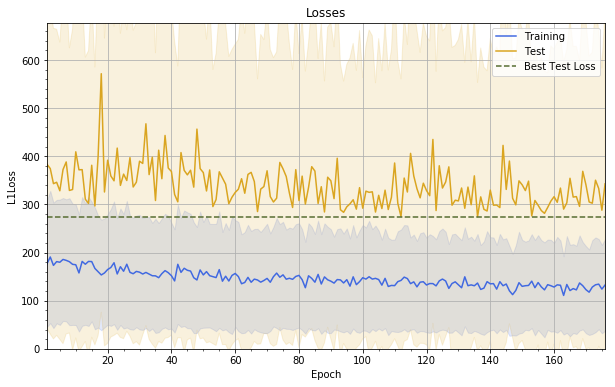

In [2]:
_ = cnn.train(
    epochs=250,
    training_data=dataset,
    k_cv_folds=3,
    early_stopping_patience=40)

_ = cnn.train(
    epochs=250,
    training_data=dataset,
    k_cv_folds=3,
    early_stopping_patience=40)

Lastly we persist the trained model.

In [3]:
#cnn.save_model(False)

Saving the model to /home/nevape/projektit/crop-yield-cnn/models/cnn_3x128x128_8cnn_2fc.pkl


## Assessing Model Performance

Then we will load the model and produce a table of true and predicted targets.

In [3]:
import torch
import os
import pandas as pd
import matplotlib.pyplot as plt

cnn.load_model()

Reading the model from /home/nevape/projektit/crop-yield-cnn/models/cnn_3x128x128_8cnn_2fc.pkl


In [4]:
y_trues, y_preds = [],[]
with torch.set_grad_enabled(False):
    for item in dataset:
        y_trues.append(item['y'].item())
        y_preds.append(cnn(item['x'].unsqueeze(0).float().cuda()).item())

df = pd.DataFrame(columns=['y_true','y_pred'])
df.loc[:,'y_true'] = y_trues
df.loc[:,'y_pred'] = y_preds
df.to_csv(os.path.join(os.getcwd(),'results','targets_predictions.csv'))

We will first just visualize the values as overlapping histograms to see how the values spread out.

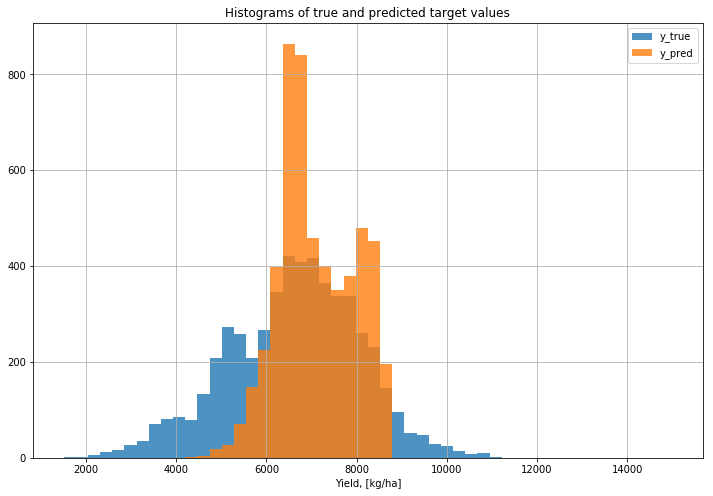

In [14]:
plt.rcParams['figure.figsize'] = 12,8
plt.hist(df.y_true,bins=50,range=(1500,15000),label='y_true',alpha=0.8)
plt.hist(df.y_pred,bins=50,range=(1500,15000),label='y_pred',alpha=0.8)
plt.grid()
plt.legend()
plt.title('Histograms of true and predicted target values')
plt.xlabel('Yield, [kg/ha]')
plt.show()

Then we'll plot out the histogram of row-wise errors.

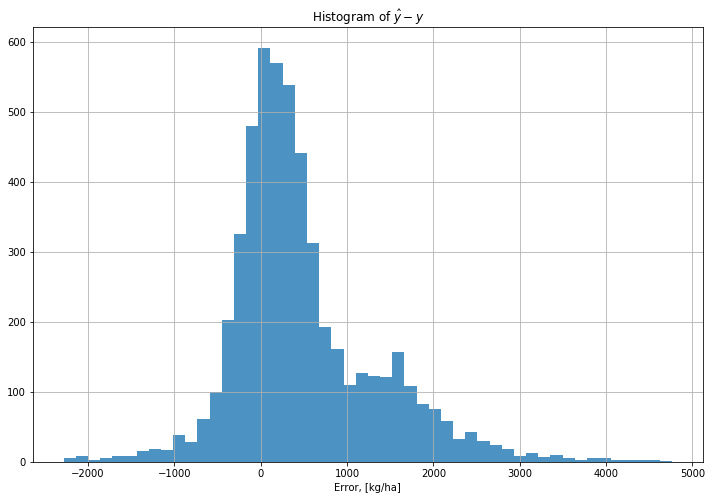

In [20]:
plt.hist((df.y_pred-df.y_true),bins=50,alpha=0.8)
plt.grid()
plt.title('Histogram of $\hat{y}-y$')
plt.xlabel('Error, [kg/ha]')
plt.show()